In [1]:
import requests
from pymongo import MongoClient
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate

plt.style.use('ggplot')

In [2]:
#set up Mongo to store data 
client = MongoClient('localhost', 27017)

db = client['cap1_db']
col1 = db['col1']
col_people = db['col_people']


In [3]:
category_url = ['Data_scientists', 
                '20th-century_economists',
                '21st-century_economists', 
                '21st-century_chemists', 
                '20th-century_chemists',
                '21st-century_physicists',
                '20th-century_physicists',
                '21st-century_biologists',
                '20th-century_biologists',
                'Microbiologists',
                '21st-century_physicians',
                '20th-century_physicians']

nobel = ['Data Science', 
            'Economics',
           'Chemistry',
           'Physics' ,
           'Physiology or Medicine']

subcat_dict = dict()
for i in category_url:
    doc = col1.find_one({'page': i })
    subcat_dict[i] = doc['subcat_link']
subcat_dict2 = dict()
subcategory_category_url = []
for i in category_url: 
    doc = col1.find_one({'page': i})
    subcat_list = doc['subcat_link']
    for subcat in subcat_list:
        subcat = subcat.replace('/wiki/Category:', '')
        subcategory_category_url.append(subcat)
        subdoc = col1.find_one({'page': subcat })
        try:
            subcat_dict2[subcat] = subdoc['subcat_link']
        except:
            subcat_dict2[subcat] = None

In [4]:
full_subcat_dict = {}
for k, v in subcat_dict.items():
    for cat in v:
        cat = cat.replace('/wiki/Category:', '')
        for k2, v2 in subcat_dict2.items():
            if cat == k2:
                sub_dict = {k2:v2}
                if k not in full_subcat_dict:
                    full_subcat_dict[k] = sub_dict
                elif k in full_subcat_dict:
                    full_subcat_dict[k].update(sub_dict)

for k, v in full_subcat_dict.items():
    for k2, v2, in full_subcat_dict[k].items():
        fix_list = []
        try:
            for cat in v2:
                cat = cat.replace('/wiki/Category:', '')
                fix_list.append(cat)
        except:
            continue
        full_subcat_dict[k][k2] = fix_list

flat_dict = {}
for k, v in full_subcat_dict.items():
    flatten = []
    for k2, v2 in v.items():
        flatten.append(k2)
        try:
            for i in v2:
                flatten.append(i)
        except:
            continue
    flat_dict[k] = flatten


In [5]:
cat_origin_dict = {'Data Science': ['Data_scientists'] , 
            'Economics': ['20th-century_economists',
                '21st-century_economists'],
           'Chemistry': ['21st-century_chemists', 
                '20th-century_chemists'] ,
           'Physics' : ['21st-century_physicists',
                '20th-century_physicists'] ,
           'Physiology or Medicine' : ['21st-century_biologists',
                '20th-century_biologists',
                'Microbiologists',
                '21st-century_physicians',
                '20th-century_physicians']}

In [6]:
def invert_dictionary(d):
    d_out = dict()
    for k, v in d.items():
        for val in v:
            if val not in d_out:
                d_out[val] = set()
                d_out[val]= k
    return d_out

field_dct = invert_dictionary(flat_dict)

def merge_dictionaries(d1, d2):

    d = d1.copy()
    for key, value in d2.items():
        if key in d:
            continnue
        else:
            d[key] = key
    return d

d_original = {}
d_original = d_original.fromkeys(category_url)

field_dct = merge_dictionaries(field_dct, d_original)

In [7]:
cat_origin = invert_dictionary(cat_origin_dict)
cat_origin

{'Data_scientists': 'Data Science',
 '20th-century_economists': 'Economics',
 '21st-century_economists': 'Economics',
 '21st-century_chemists': 'Chemistry',
 '20th-century_chemists': 'Chemistry',
 '21st-century_physicists': 'Physics',
 '20th-century_physicists': 'Physics',
 '21st-century_biologists': 'Physiology or Medicine',
 '20th-century_biologists': 'Physiology or Medicine',
 'Microbiologists': 'Physiology or Medicine',
 '21st-century_physicians': 'Physiology or Medicine',
 '20th-century_physicians': 'Physiology or Medicine'}

In [8]:
dfcsv = pd.read_csv('data/wiki_profile.csv')
dfcsv = dfcsv.drop('Unnamed: 0',1)
dfcsv.reset_index()
dfcsv[['count_female_words', 'count_male_words', 'count_nonbinary_words', 'len_page']].astype(int)
dfcsv['doctorate'].astype(bool)
dfcsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18212 entries, 0 to 18211
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   page                   18212 non-null  object
 1   field                  18212 non-null  object
 2   count_female_words     18212 non-null  int64 
 3   count_male_words       18212 non-null  int64 
 4   count_nonbinary_words  18212 non-null  int64 
 5   doctorate              18212 non-null  int64 
 6   len_page               18212 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 996.1+ KB


In [9]:
# Check nonbinary
dfcsv['female'] = [True if (x > y) and (x > z)                   
                   else False 
                   for x, y, z in zip(dfcsv['count_female_words'], dfcsv['count_male_words'], dfcsv['count_nonbinary_words'])]

dfcsv['male'] = [True if (y > x) and (y > z)                   
                   else False 
                   for x, y, z in zip(dfcsv['count_female_words'], dfcsv['count_male_words'], dfcsv['count_nonbinary_words'])]

dfcsv['nonbinary'] = [True if (z > x) and (z > y)                   
                   else False 
                   for x, y, z in zip(dfcsv['count_female_words'], dfcsv['count_male_words'], dfcsv['count_nonbinary_words'])]

non_binary = dfcsv[dfcsv['nonbinary']==True]
dfcsv[['female', 'male', 'nonbinary']].sum()

female        3703
male         14013
nonbinary       59
dtype: int64

In [10]:
# it would appear that people categorized as nonbinary had more nonbinary words 'they, them' than male or female indicator words by chance

In [11]:
dfcsv['female'] = [True if x > y              
                   else False 
                   for x, y in zip(dfcsv['count_female_words'], dfcsv['count_male_words'])]

dfcsv['male'] = [True if y > x                   
                   else False 
                   for x, y in zip(dfcsv['count_female_words'], dfcsv['count_male_words'])]
dfcsv['gender_unclear'] = [True if y == x                   
                   else False 
                   for x, y in zip(dfcsv['count_female_words'], dfcsv['count_male_words'])]

dfcsv[['female', 'male', 'gender_unclear']].sum()

female             3708
male              14074
gender_unclear      430
dtype: int64

In [12]:
non_binary = dfcsv[dfcsv['gender_unclear']==True]
#where gender is unclear, it appears that these profiles tend to be in another language or are too short
#for example: https://en.wikipedia.org/wiki/Ren%C3%A9_Courtin
#https://en.wikipedia.org/wiki/Auguste_Det%C5%93uf
# https://en.wikipedia.org/wiki/Jules_L%C3%A9on_Austaut

dfcsv = dfcsv[dfcsv['gender_unclear']==False]

In [13]:
category = []
here = []
for field in dfcsv['field']:
    if field in field_dct:
        category.append(field_dct[field])
        here.append(1)
    else:
        category.append(field)
        here.append(0)

dfcsv['category'] = category
dfcsv['count'] = here


In [14]:
bigger_category = []
for cat in dfcsv['category']:
    if cat in cat_origin:
        bigger_category.append(cat_origin[cat])

    else:
        print("why don't i exist?")

dfcsv['nobel_field'] = bigger_category

In [15]:
df_analysis = dfcsv[['page', 'doctorate', 'len_page', 'female', 'male', 'category', 'count', 'nobel_field']]

In [16]:
group_field_avg = df_analysis.groupby('nobel_field').mean(['doctorate', 'len_page', 'female', 'male'])
group_field_avg = group_field_avg.reset_index()
group_field_avg = group_field_avg[['female', 'doctorate']]
group_field_sum = df_analysis.groupby('nobel_field').sum()
group_field_sum = group_field_sum.reset_index()
group_field_sum = group_field_sum[['nobel_field','count']]

In [17]:
#Data Description Table
data_desc = pd.concat([group_field_sum, group_field_avg], axis=1).sort_values('count')
print(tabulate(data_desc, floatfmt=".3f", headers=['Field', 'N', 'Female (proportion)', 'Ph.D (proportion)'], tablefmt="github"))

|    | Field                  |     N |   Female (proportion) |   Ph.D (proportion) |
|----|------------------------|-------|-----------------------|---------------------|
|  1 | Data Science           |    63 |                 0.365 |               0.302 |
|  0 | Chemistry              |  1659 |                 0.234 |               0.429 |
|  2 | Economics              |  2576 |                 0.145 |               0.395 |
|  3 | Physics                |  2837 |                 0.159 |               0.417 |
|  4 | Physiology or Medicine | 10647 |                 0.232 |               0.139 |


In [18]:

gender_se_dct = {}

for field in nobel:
    gender_byfield = df_analysis['female'][df_analysis['nobel_field']==field]
    
    gender_se = ((gender_byfield.mean()*(1-gender_byfield.mean()))/len(gender_byfield))**.5
    gender_se_dct[field] = gender_se

    
gender_se = pd.DataFrame(list(gender_se_dct.items()), columns = ['nobel_field', 'gender_se'])
data_desc = data_desc[['nobel_field', 'female']]
prop_gender_bycat = pd.merge(gender_se, data_desc, how='inner', on='nobel_field')
prop_gender_bycat = prop_gender_bycat.sort_values('female', ascending=True)

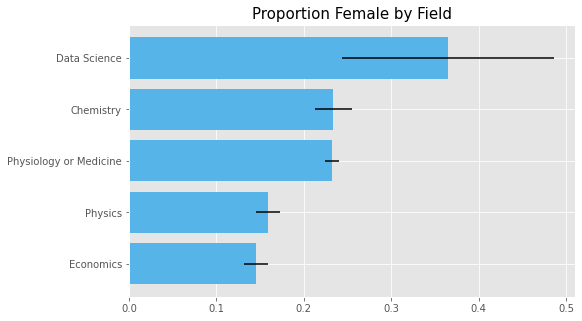

In [19]:
x = prop_gender_bycat['nobel_field']
y = prop_gender_bycat['female']
gender_se_double = [x*2 for x in prop_gender_bycat['gender_se']]

fig, ax = plt.subplots(figsize=(8,5))
#could calculate variance and add error bars

ax.barh(x, y, xerr=gender_se_double, color="#56B4E9")

ax.set_title('Proportion Female by Field', size = 15)

fig.savefig('images/PropWomenbyfield.png', bbox_inches = "tight")

In [20]:
print_cat_dict = {'Data_scientists':'Data Scientists', 
                '20th-century_economists':'20th Century Economists',
                '21st-century_economists':'21st Century Economists', 
                '21st-century_chemists':'21st Century Chemists', 
                '20th-century_chemists':'20th Century Chemists',
                '21st-century_physicists':'21st Century Physicists',
                '20th-century_physicists':'20th Century Physicists',
                '21st-century_biologists':'21st Century Biologists',
                '20th-century_biologists':'20th Century Biologists',
                'Microbiologists':'Microbiologists',
                '21st-century_physicians':'21st Century Physicians',
                '20th-century_physicians':'20th Century Physicians'}

In [21]:
group_cat = df_analysis.groupby(['category'])

gender_se_dct = {}
for category in category_url:
    gender_bycategory = df_analysis['female'][df_analysis['category']==category]
    
    gender_se = ((gender_bycategory.mean()*(1-gender_bycategory.mean()))/len(gender_bycategory))**.5
    gender_se_dct[category] = gender_se

    
gender_se = pd.DataFrame(list(gender_se_dct.items()), columns = ['category', 'gender_se'])

group_cat = group_cat.mean().reset_index()
group_cat = group_cat[['category','female']]
prop_gender_bycat = pd.merge(gender_se, group_cat, how='inner', on='category')
prop_gender_bycat = prop_gender_bycat[(prop_gender_bycat['category'] != 'Microbiologists') & (prop_gender_bycat['category'] != 'Data_scientists')]


In [25]:
temp_field = {}
for x in prop_gender_bycat['category']:
    field_name = x.split("_")
    field_name = field_name[-1]
    temp_field[x] = field_name

temp_field_elems = []
for cat in prop_gender_bycat['category']:
    if cat in temp_field:
        temp_field_elems.append(temp_field[cat])
    else:
        print("why don't i exist?")

prop_gender_bycat['temp_field'] = temp_field_elems
prop_gender_bycat

,category,gender_se,female,temp_field
8,20th-century_biologists,0.006382,0.187600,biologists
4,20th-century_chemists,0.012777,0.193515,chemists
1,20th-century_economists,0.007837,0.116736,economists
11,20th-century_physicians,0.005954,0.191055,physicians
6,20th-century_physicists,0.009096,0.138600,physicists
7,21st-century_biologists,0.014803,0.376284,biologists
3,21st-century_chemists,0.017092,0.288762,chemists
2,21st-century_economists,0.013316,0.198439,economists
10,21st-century_physicians,0.018933,0.368259,physicians
5,21st-century_physicists,0.010275,0.179340,physicists


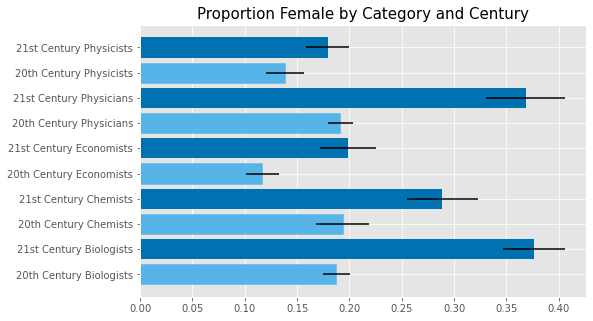

In [26]:
prop_gender_bycat = prop_gender_bycat.sort_values('category')
prop_gender_bycat = prop_gender_bycat.sort_values('temp_field')
prop_gender_bycat.reset_index()
x = prop_gender_bycat['category']
pretty_x = [print_cat_dict[x_elem] for x_elem in x]

gender_se_double = [x*2 for x in prop_gender_bycat['gender_se']]


# The palette with grey:
# cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

y = prop_gender_bycat['female']

fig, ax = plt.subplots(figsize=(8,5))
#could calculate variance and add error bars

bars = ax.barh(pretty_x, y, color = "#0072B2", 
                xerr=gender_se_double)
for item in bars[::2]:
    item.set_color("#56B4E9")
    
ax.set_title('Proportion Female by Category and Century', size = 15)


fig.savefig('images/PropWomenbyCategory.png', bbox_inches = "tight")

In [27]:
group_cat_gender = df_analysis.groupby(['category','female']).sum()
group_cat_gender['prop_phd'] = group_cat_gender['doctorate'] / group_cat_gender['count']
group_cat_gender = group_cat_gender.reset_index()
group_cat_gender = group_cat_gender.sort_values('prop_phd')


In [28]:

for field in nobel:
    test_f = df_analysis[(df_analysis['female']==True) & (df_analysis['nobel_field']==field)]
    test_f = test_f['doctorate']
    test_m = df_analysis[(df_analysis['female']==False) & (df_analysis['nobel_field']==field)]
    test_m = test_m['doctorate']

    stat, pval = stats.ttest_ind(test_f, test_m, equal_var=False)
    
    difference = test_m.mean()-test_f.mean()
    
    alpha = .01

    if pval > alpha:
        print(f"{field} : diff: {difference:.4f} P-value = {pval:.4f}")

    elif pval < alpha:
        print(f"{field} : diff: {difference:.4f} P-value = {pval:.4f}**")


Data Science : diff: 0.2011 P-value = 0.0780
Economics : diff: -0.0100 P-value = 0.7156
Chemistry : diff: -0.0756 P-value = 0.0091**
Physics : diff: 0.0180 P-value = 0.4769
Physiology or Medicine : diff: -0.0726 P-value = 0.0000**


In [29]:
group_by_cat_gender = df_analysis.groupby(['nobel_field', 'female'])

#standard errors 
se_fem_dct = {}
se_male_dct = {}

for field in nobel:
    df_male_phd = df_analysis['doctorate'][(df_analysis['nobel_field']==field) & (df_analysis['female']==False)]
    df_female_phd = df_analysis['doctorate'][(df_analysis['nobel_field']==field) & (df_analysis['female']==False)]
    
    women_phd_se = ((df_female_phd.mean()*(1-df_female_phd.mean()))/len(df_female_phd))**.5
    men_phd_se = ((df_male_phd.mean()*(1-df_male_phd.mean()))/len(df_male_phd))**.5
    se_fem_dct[field] = women_phd_se
    se_male_dct[field] = men_phd_se

se_fem_phd = pd.DataFrame(list(se_fem_dct.items()), columns = ['nobel_field', 'fem_phd_se'])
se_male_phd = pd.DataFrame(list(se_male_dct.items()), columns = ['nobel_field', 'male_phd_se'])
phd_se = pd.merge(se_fem_phd, se_male_phd, how='inner', on='nobel_field')

group_by_cat_gender_mean = group_by_cat_gender.mean()
phd_group_cat_gender = group_by_cat_gender_mean['doctorate']
phd_group_cat_gender = phd_group_cat_gender.reset_index()

female_phd = phd_group_cat_gender[phd_group_cat_gender['female'] == True]
male_phd = phd_group_cat_gender[phd_group_cat_gender['female'] == False]

male_phd = male_phd.filter(['nobel_field', 'doctorate'])
male_phd.rename(columns = {'doctorate':'male_phd'}, inplace=True)
female_phd = female_phd.filter(['nobel_field', 'doctorate'])
female_phd.rename(columns = {'doctorate':'female_phd'}, inplace=True)

prop_phd_bycat = pd.merge(male_phd, female_phd, how='inner', on='nobel_field')
prop_phd_bycat = pd.merge(prop_phd_bycat, phd_se, how='inner', on='nobel_field')

prop_phd_bycat.sort_values('male_phd', inplace=True)
prop_phd_bycat
    

,nobel_field,male_phd,female_phd,fem_phd_se,male_phd_se
4,Physiology or Medicine,0.122339,0.194905,0.003624,0.003624
1,Data Science,0.375000,0.173913,0.076547,0.076547
2,Economics,0.393733,0.403743,0.010412,0.010412
0,Chemistry,0.411487,0.487113,0.013803,0.013803
3,Physics,0.420193,0.402222,0.010103,0.010103


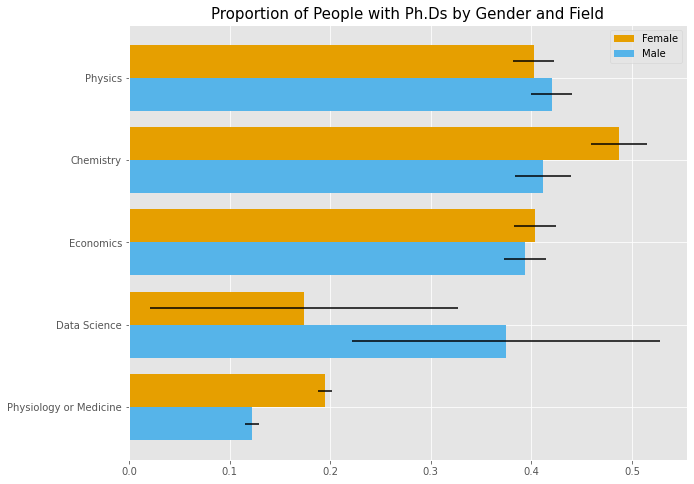

In [35]:
categories = prop_phd_bycat['nobel_field']
y_male = prop_phd_bycat['male_phd']
y_fem = prop_phd_bycat['female_phd']

male_se = prop_phd_bycat['male_phd_se']
fem_se = prop_phd_bycat['fem_phd_se']
male_se_double = [x*2 for x in male_se]
fem_se_double = [x*2 for x in fem_se]

fig, ax = plt.subplots(figsize=(10,8))

N = len(categories) 
ind = np.arange(N) 
width = .4
f = ax.barh(ind+width, y_fem, width, label = 'Female', xerr=fem_se_double, color="#E69F00")
m = ax.barh(ind, y_male, width, label = 'Male', xerr=male_se_double, color="#56B4E9" )

plt.yticks(ind + width / 2, categories, size=10)
plt.legend(loc='best')

ax.set_title('Proportion of People with Ph.Ds by Gender and Field', size=15)

fig.savefig('images/PropPhD_gender_field.png', bbox_inches = "tight")